## Reduced Rank Regression

In [40]:
import os
import pickle as pkl
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from utils.helpers import *

# autoreload
%reload_ext autoreload
%autoreload 2

In [4]:
# Load the data
current_dir = os.getcwd()
print("Loading the data...")
data_path = os.path.join(current_dir, 'data')
data = load_data(data_path, 'ssp585_time_series.pkl')
print("Data loaded successfully!")

Loading the data...
Data loaded successfully!


In [5]:
filtered_data = filter_data(data)

100%|██████████| 72/72 [00:00<00:00, 67604.63it/s]


In [11]:
# Create a NaN mask to remove any cells which have 1 >= NaNs

nan_mask = create_nan_mask(filtered_data)

100%|██████████| 34/34 [00:01<00:00, 19.80it/s]


In [ ]:
# Apply the NaN mask to every single run (modifications done in place for memory efficiency)

masked_data = mask_out_nans(filtered_data, nan_mask)

100%|██████████| 34/34 [00:01<00:00, 30.03it/s]


## The NaN mask has been applied and only the models with more than 4 runs have been kept

In [16]:
print(f"There are exactly {len(masked_data.keys())} models of the {len(data.keys())} that remain.")

There are exactly 34 models of the 72 that remain.


In [18]:
reshaped_data = reshape_data(masked_data)

100%|██████████| 34/34 [00:03<00:00,  9.77it/s]


In [19]:
example_model = 'CanESM5-1'
example_model_data = reshaped_data[example_model]
print(f"Selected model: {example_model}, which has {len(example_model_data)} runs.")

Selected model: CanESM5-1, which has 72 runs.


In [ ]:
first_example_model_run = example_model_data[list(example_model_data.keys())[0]]
first_example_model_run.shape # Shape: (Time x (Latitude x Longitude))

(165, 10368)

### Calculate the forced response for each model, assuming that it is the mean of all the runs

In [22]:
data_forced_responses = add_forced_response(reshaped_data) # The forced response is not correctly normalized yet (this is done by the normalize function below)

100%|██████████| 34/34 [00:04<00:00,  8.00it/s]


In [41]:
data_without_nans = remove_nans_from_grid(data_forced_responses, nan_mask)

### The data is now in the shape : Time x # of grid cells 

In [45]:
# Select one of the models randomly for testing and the rest for training according to the leave-one-out strategy
test_model = random.choice(list(data_without_nans.keys()))
train_models = [model for model in data_without_nans.keys() if model != test_model]

# Create the training and testing datasets
train_data = {model: data_without_nans[model] for model in train_models}
test_data = {test_model: data_without_nans[test_model]}

print(f"Training models: {train_models}")
print(f"Testing model: {test_model}")

Training models: ['ICON-ESM-LR', 'CMCC-CM2-SR5', 'ACCESS-CM2', 'CESM2', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'GISS-E2-2-G', 'CNRM-CM6-1', 'CanESM5-1', 'E3SM-2-0-NARRM', 'HadGEM3-GC31-LL', 'MIROC-ES2L', 'GISS-E2-1-H', 'E3SM-2-0', 'GISS-E2-1-G', 'EC-Earth3-Veg', 'ACCESS-ESM1-5', 'HadGEM3-GC31-MM', 'FGOALS-g3', 'E3SM-1-0', 'MPI-ESM1-2-HR', 'CanESM5', 'CAS-ESM2-0', 'MIROC6', 'NESM3', 'GISS-E2-2-H', 'MPI-ESM1-2-LR', 'AWI-CM-1-1-MR', 'UKESM1-0-LL', 'NorCPM1', 'INM-CM5-0', 'MRI-ESM2-0', 'CESM2-FV2']
Testing model: EC-Earth3


In [14]:
test_data.keys()

dict_keys(['GISS-E2-1-H'])

In [15]:
# Normalize the data
normalized_train_data, normalized_test_data, training_statistics, testing_statistics = normalize_data(train_data, test_data)

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


## Now that the data has been normalized (and NaN values removed), it's time to do the Reduced Rank Regression (RRR)

In [16]:
# First pool the data together
X_full, Y_full = pool_data(normalized_train_data)

In [17]:
X_full.shape, Y_full.shape # Shape is correct

((119625, 6523), (119625, 6523))

In [18]:
rank = 3000 # Used as a starting point
lambda_ = 0.01 # This will be optimized later
Brr, B_ols = reduced_rank_regression(X_full, Y_full, rank, lambda_)

In [19]:
print(Brr.shape)

(6523, 6523)


In [20]:
# Test a prediction on the test set for a single run

# Select a random run from the test set
test_model = list(normalized_test_data.keys())[0]
test_runs = [run for run in normalized_test_data[test_model].keys() if run != 'forced_response']
test_run = normalized_test_data[test_model][random.choice(test_runs)]
ground_truth = normalized_test_data[test_model]['forced_response']

In [21]:
test_run.shape, ground_truth.shape

((165, 6523), (165, 6523))

In [22]:
# make the prediction

prediction = test_run @ Brr
prediction.shape

(165, 6523)

In [23]:
# Add the NaN values back to the correct spots
predictions = True
prediction = readd_nans(prediction, nan_mask, predictions)
test_run = readd_nans(test_run, nan_mask, predictions)
ground_truth = readd_nans(ground_truth, nan_mask, predictions)

In [24]:
prediction.shape, test_run.shape, ground_truth.shape

((165, 10368), (165, 10368), (165, 10368))

Displaying the forced response and runs for grid spot: [39 47]


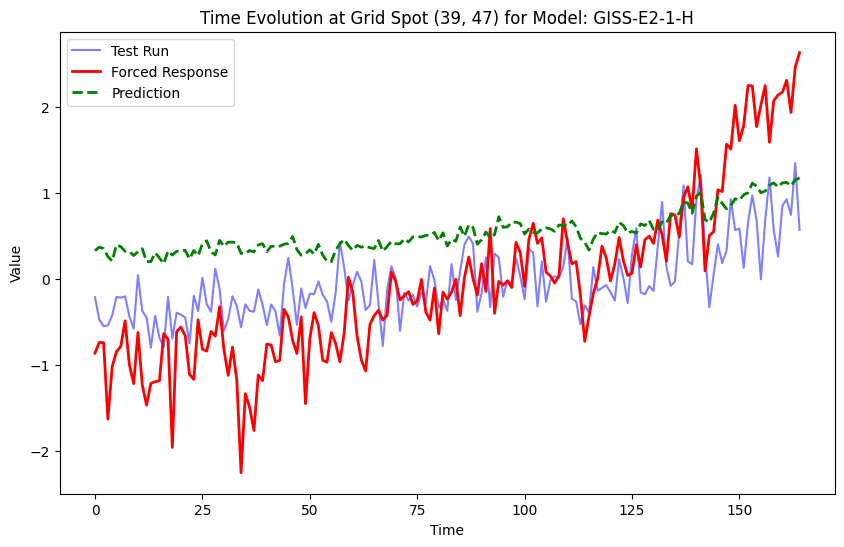

In [ ]:
# Select a random grid spot
valid_grid_spots = np.argwhere(~nan_mask)
random_grid_spot = valid_grid_spots[random.randint(0, len(valid_grid_spots))]
print(f"Displaying the forced response and runs for grid spot: {random_grid_spot}")

# Data for each run (minus the forced response)
input_data = test_run.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]
# Data for the forced response
forced_response_data = ground_truth.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]
# Data for the prediction
predicted_data = prediction.reshape(-1, 72, 144)[:, random_grid_spot[0], random_grid_spot[1]]

# Plot the time series data for all runs, the forced response, and the prediction
plt.figure(figsize=(10, 6))
plt.plot(input_data, color='blue', alpha=0.5, label='Test Run')
plt.plot(forced_response_data, color='red', label='Forced Response', linewidth=2)
plt.plot(predicted_data, color='green', label='Prediction', linewidth=2, linestyle='--')
plt.title(f'Time Evolution at Grid Spot ({random_grid_spot[0]}, {random_grid_spot[1]}) for Model: {test_model}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [26]:
print(f"The shape of the data is: {X_full.shape}")
print(f"The shape of the target is: {Y_full.shape}")
print(f"The maximum, minimum, average and std for the input data are: {np.max(X_full)}, {np.min(X_full)}, {np.mean(X_full)}, {np.std(X_full)}")
print(f"The maximum, minimum, average and std for the target data are: {np.max(Y_full)}, {np.min(Y_full)}, {np.mean(Y_full)}, {np.std(Y_full)}")

The shape of the data is: (119625, 6523)
The shape of the target is: (119625, 6523)
The maximum, minimum, average and std for the input data are: 167.02204344403054, -7610.598601598949, -0.20052953280444144, 13.195962780264187
The maximum, minimum, average and std for the target data are: 165.4961780244595, -7608.745755742709, -0.20052953280443458, 13.158017848373659
